In [1]:
import matplotlib.pyplot as plt
import numpy as np

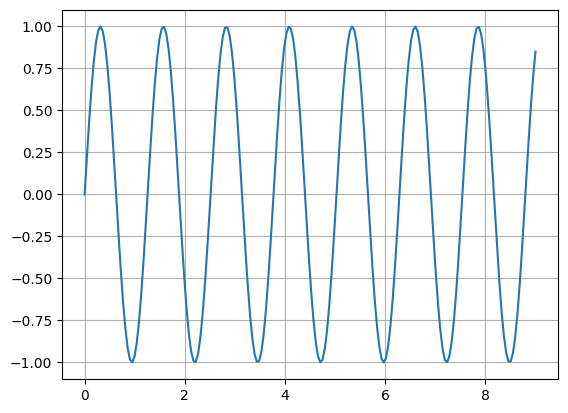

In [19]:
x = np.linspace(0, 9, 200)
y = np.sin(5*x)
plt.plot(x,y)
plt.grid(True)
plt.show()

(-1+0j)
